# Day 1: Logistic Regression for Trading Signal Classification

## 🎯 Learning Objectives
- Transform return prediction to classification
- Master logistic regression fundamentals
- Interpret probabilities for position sizing
- Build trading signals from binary classification

---

## 📚 Theory: Logistic Regression

### Why Classification for Trading?
Instead of predicting exact returns (hard), predict:
- Will the stock go UP or DOWN?
- Is this a BUY, HOLD, or SELL?

### The Logistic Function
$$P(y=1|x) = \sigma(x^T\beta) = \frac{1}{1 + e^{-x^T\beta}}$$

### Log-Odds (Logit)
$$\log\left(\frac{P(y=1)}{1-P(y=1)}\right) = x^T\beta$$

### Maximum Likelihood Estimation
$$\mathcal{L}(\beta) = \prod_{i=1}^n p_i^{y_i}(1-p_i)^{1-y_i}$$

### Trading Application
- **Probability > 0.5**: Go LONG
- **Probability < 0.5**: Go SHORT/CASH
- **Position size** ∝ |Probability - 0.5| (Kelly-like)

### Pros & Cons

| Pros | Cons |
|------|------|
| Outputs probabilities | Assumes linear log-odds |
| Well-calibrated with proper tuning | Sensitive to class imbalance |
| Fast training | No feature selection (needs regularization) |
| Interpretable coefficients | Binary only (use multinomial for multi-class) |

---

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import warnings
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, confusion_matrix, 
                             classification_report, roc_curve)
import seaborn as sns

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')

TRADING_DAYS = 252
RISK_FREE_RATE = 0.05

# Download data
tickers = ['AAPL', 'MSFT', 'GOOGL', 'JPM', 'GS', 'SPY']
end_date = datetime.now()
start_date = end_date - timedelta(days=5*365)

print("📥 Downloading data...")
data = yf.download(tickers, start=start_date, end=end_date, progress=False, auto_adjust=True)
prices = data['Close'].dropna()
returns = prices.pct_change().dropna()

print(f"✅ Data: {len(returns)} days, {len(tickers)} assets")

📥 Downloading data...
✅ Data: 1255 days, 6 assets


In [2]:
# Feature Engineering
target_stock = 'AAPL'
df = pd.DataFrame(index=returns.index)

# Momentum features
df['momentum_5'] = prices[target_stock].pct_change(5)
df['momentum_10'] = prices[target_stock].pct_change(10)
df['momentum_20'] = prices[target_stock].pct_change(20)

# Volatility
df['volatility_10'] = returns[target_stock].rolling(10).std()
df['volatility_20'] = returns[target_stock].rolling(20).std()

# Moving average signals
df['ma_5_20'] = prices[target_stock].rolling(5).mean() / prices[target_stock].rolling(20).mean() - 1
df['ma_10_50'] = prices[target_stock].rolling(10).mean() / prices[target_stock].rolling(50).mean() - 1

# Market features
df['spy_return'] = returns['SPY']
df['spy_momentum'] = prices['SPY'].pct_change(5)

# RSI (Relative Strength Index)
delta = prices[target_stock].diff()
gain = delta.where(delta > 0, 0).rolling(14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(14).mean()
rs = gain / loss
df['rsi'] = 100 - (100 / (1 + rs))

# Binary target: 1 if next day return > 0
df['next_return'] = returns[target_stock].shift(-1)
df['target'] = (df['next_return'] > 0).astype(int)

df = df.dropna()

print(f"\n📊 Features: {len(df.columns)-2}")
print(f"📈 Samples: {len(df)}")
print(f"\n🎯 Class Distribution:")
print(df['target'].value_counts(normalize=True))


📊 Features: 10
📈 Samples: 1206

🎯 Class Distribution:
target
1    0.529851
0    0.470149
Name: proportion, dtype: float64


In [3]:
# Prepare data
feature_cols = [c for c in df.columns if c not in ['target', 'next_return']]
X = df[feature_cols]
y = df['target']

# Time-series split
split_idx = int(len(df) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]
returns_test = df['next_return'].iloc[split_idx:]

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Train: {len(X_train)}, Test: {len(X_test)}")

Train: 964, Test: 242


In [4]:
# Train Logistic Regression with Cross-Validation
tscv = TimeSeriesSplit(n_splits=5)

# Regularized Logistic Regression (L2)
lr_cv = LogisticRegressionCV(cv=tscv, Cs=20, penalty='l2', 
                             solver='lbfgs', max_iter=1000, random_state=42)
lr_cv.fit(X_train_scaled, y_train)

print(f"\n✅ Optimal C (inverse regularization): {lr_cv.C_[0]:.4f}")
print(f"   CV Accuracy: {lr_cv.scores_[1].mean():.2%}")


✅ Optimal C (inverse regularization): 0.0001
   CV Accuracy: 51.67%


In [5]:
# Predictions and Probabilities
y_pred = lr_cv.predict(X_test_scaled)
y_proba = lr_cv.predict_proba(X_test_scaled)[:, 1]  # Probability of class 1 (up)

print("\n" + "="*60)
print("CLASSIFICATION PERFORMANCE")
print("="*60)
print(f"\nAccuracy: {accuracy_score(y_test, y_pred):.2%}")
print(f"Precision: {precision_score(y_test, y_pred):.2%}")
print(f"Recall: {recall_score(y_test, y_pred):.2%}")
print(f"F1 Score: {f1_score(y_test, y_pred):.2%}")
print(f"AUC-ROC: {roc_auc_score(y_test, y_proba):.4f}")

print("\n" + classification_report(y_test, y_pred, target_names=['Down', 'Up']))


CLASSIFICATION PERFORMANCE

Accuracy: 52.48%
Precision: 52.48%
Recall: 100.00%
F1 Score: 68.83%
AUC-ROC: 0.5276

              precision    recall  f1-score   support

        Down       0.00      0.00      0.00       115
          Up       0.52      1.00      0.69       127

    accuracy                           0.52       242
   macro avg       0.26      0.50      0.34       242
weighted avg       0.28      0.52      0.36       242



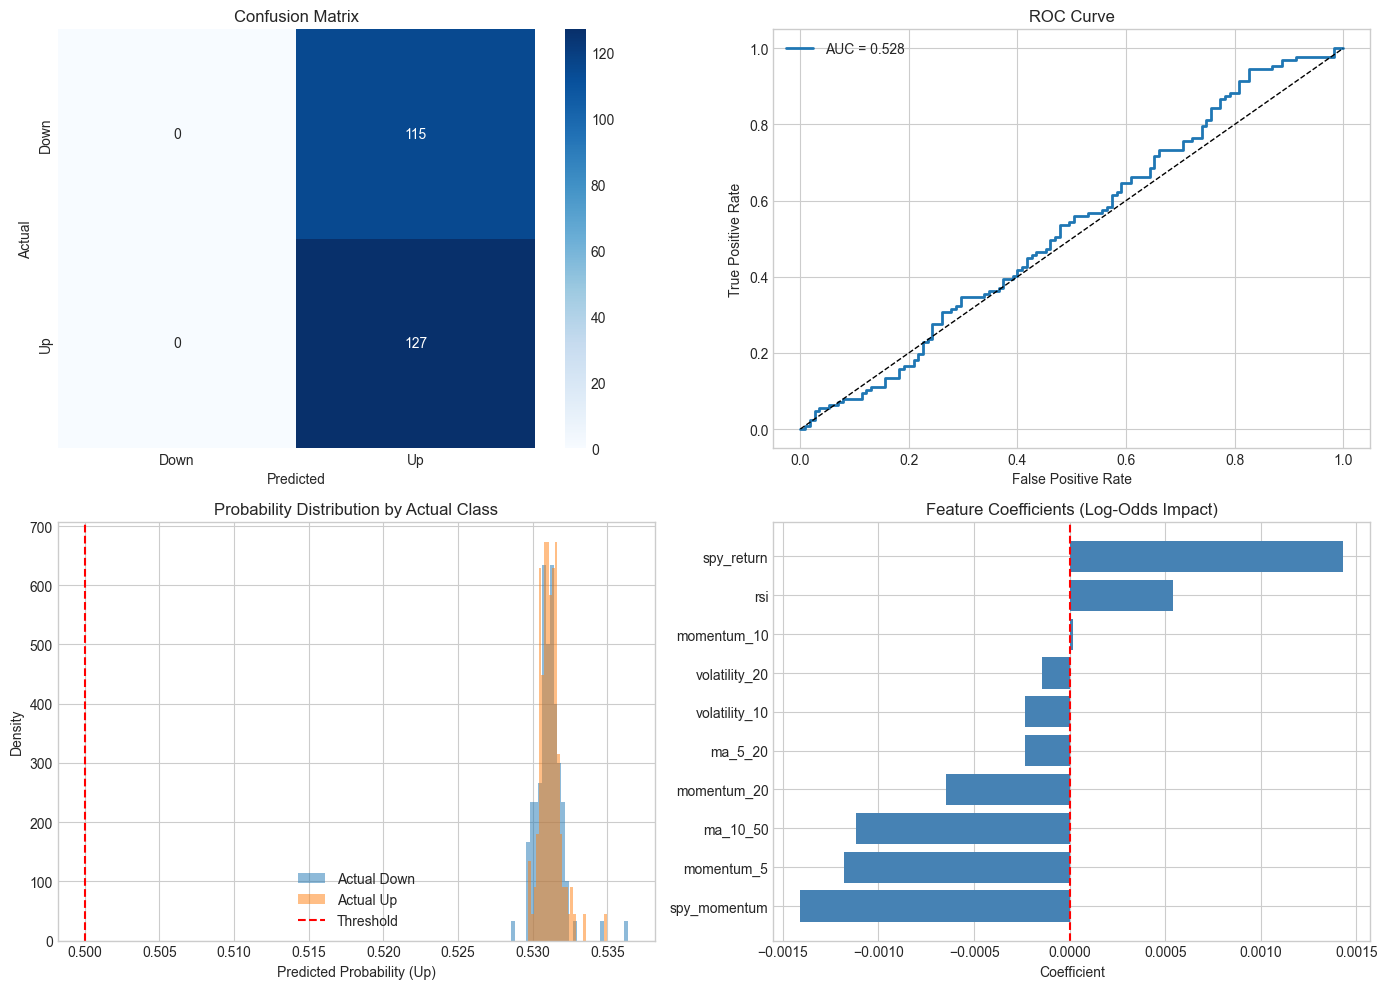

In [6]:
# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0, 0])
axes[0, 0].set_xlabel('Predicted')
axes[0, 0].set_ylabel('Actual')
axes[0, 0].set_title('Confusion Matrix')
axes[0, 0].set_xticklabels(['Down', 'Up'])
axes[0, 0].set_yticklabels(['Down', 'Up'])

# 2. ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
axes[0, 1].plot(fpr, tpr, linewidth=2, label=f'AUC = {roc_auc_score(y_test, y_proba):.3f}')
axes[0, 1].plot([0, 1], [0, 1], 'k--', linewidth=1)
axes[0, 1].set_xlabel('False Positive Rate')
axes[0, 1].set_ylabel('True Positive Rate')
axes[0, 1].set_title('ROC Curve')
axes[0, 1].legend()

# 3. Probability Distribution
axes[1, 0].hist(y_proba[y_test == 0], bins=30, alpha=0.5, label='Actual Down', density=True)
axes[1, 0].hist(y_proba[y_test == 1], bins=30, alpha=0.5, label='Actual Up', density=True)
axes[1, 0].axvline(x=0.5, color='r', linestyle='--', label='Threshold')
axes[1, 0].set_xlabel('Predicted Probability (Up)')
axes[1, 0].set_ylabel('Density')
axes[1, 0].set_title('Probability Distribution by Actual Class')
axes[1, 0].legend()

# 4. Feature Coefficients
coef_df = pd.DataFrame({'Feature': feature_cols, 'Coefficient': lr_cv.coef_[0]})
coef_df = coef_df.sort_values('Coefficient')
axes[1, 1].barh(coef_df['Feature'], coef_df['Coefficient'], color='steelblue')
axes[1, 1].axvline(x=0, color='r', linestyle='--')
axes[1, 1].set_xlabel('Coefficient')
axes[1, 1].set_title('Feature Coefficients (Log-Odds Impact)')

plt.tight_layout()
plt.show()

In [7]:
# Trading Strategy: Use probabilities for position sizing
backtest = pd.DataFrame(index=y_test.index)
backtest['actual_return'] = returns_test.values
backtest['probability'] = y_proba
backtest['predicted_class'] = y_pred

# Strategy 1: Binary (all-in or out)
backtest['binary_signal'] = y_pred
backtest['binary_return'] = backtest['binary_signal'] * backtest['actual_return']

# Strategy 2: Probability-weighted (Kelly-inspired)
# Position size = 2 * (probability - 0.5), clipped to [0, 1]
backtest['prob_signal'] = np.clip(2 * (backtest['probability'] - 0.5), 0, 1)
backtest['prob_return'] = backtest['prob_signal'] * backtest['actual_return']

# Strategy 3: Threshold optimization (higher confidence)
high_threshold = 0.55
backtest['high_conf_signal'] = (backtest['probability'] > high_threshold).astype(int)
backtest['high_conf_return'] = backtest['high_conf_signal'] * backtest['actual_return']

# Cumulative returns
backtest['buy_hold_cum'] = (1 + backtest['actual_return']).cumprod()
backtest['binary_cum'] = (1 + backtest['binary_return']).cumprod()
backtest['prob_cum'] = (1 + backtest['prob_return']).cumprod()
backtest['high_conf_cum'] = (1 + backtest['high_conf_return']).cumprod()

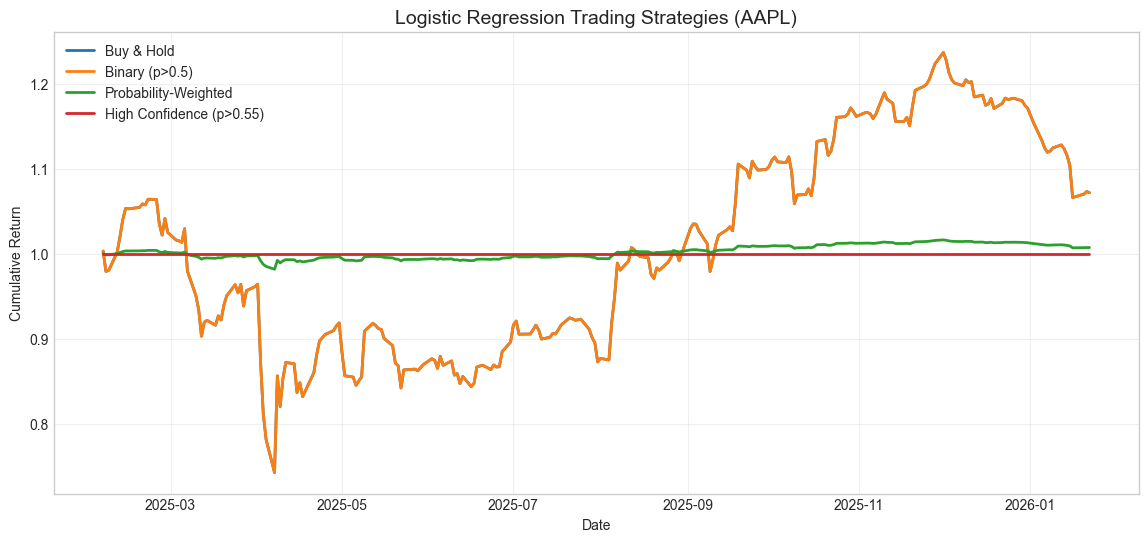

In [8]:
# Plot strategies
plt.figure(figsize=(14, 6))
plt.plot(backtest.index, backtest['buy_hold_cum'], label='Buy & Hold', linewidth=2)
plt.plot(backtest.index, backtest['binary_cum'], label='Binary (p>0.5)', linewidth=2)
plt.plot(backtest.index, backtest['prob_cum'], label='Probability-Weighted', linewidth=2)
plt.plot(backtest.index, backtest['high_conf_cum'], label=f'High Confidence (p>{high_threshold})', linewidth=2)
plt.title(f'Logistic Regression Trading Strategies ({target_stock})', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [9]:
# Performance metrics
def calc_metrics(returns, cumulative):
    total = cumulative.iloc[-1] - 1
    sharpe = (returns.mean() * TRADING_DAYS - RISK_FREE_RATE) / (returns.std() * np.sqrt(TRADING_DAYS)) if returns.std() > 0 else 0
    peak = cumulative.cummax()
    mdd = ((cumulative - peak) / peak).min()
    return total, sharpe, mdd

print("\n" + "="*60)
print("STRATEGY PERFORMANCE")
print("="*60)

strategies = ['buy_hold', 'binary', 'prob', 'high_conf']
labels = ['Buy & Hold', 'Binary', 'Prob-Weighted', 'High Confidence']

print(f"\n{'Strategy':<20} {'Total Ret':>12} {'Sharpe':>10} {'Max DD':>10}")
print("-" * 55)

for strat, label in zip(strategies, labels):
    ret_col = 'actual_return' if strat == 'buy_hold' else f'{strat}_return'
    total, sharpe, mdd = calc_metrics(backtest[ret_col], backtest[f'{strat}_cum'])
    print(f"{label:<20} {total:>12.2%} {sharpe:>10.2f} {mdd:>10.2%}")


STRATEGY PERFORMANCE

Strategy                Total Ret     Sharpe     Max DD
-------------------------------------------------------
Buy & Hold                  7.18%       0.23    -30.22%
Binary                      7.18%       0.23    -30.22%
Prob-Weighted               0.73%      -2.04     -2.21%
High Confidence             0.00%       0.00      0.00%


In [10]:
# Next Day Prediction
latest_scaled = scaler.transform(X.iloc[[-1]])
next_proba = lr_cv.predict_proba(latest_scaled)[0, 1]
next_pred = lr_cv.predict(latest_scaled)[0]

print("\n" + "="*60)
print(f"📊 NEXT DAY PREDICTION FOR {target_stock}")
print("="*60)
print(f"\nDate: {df.index[-1].strftime('%Y-%m-%d')}")
print(f"Probability (Up): {next_proba:.2%}")
print(f"Prediction: {'📈 UP' if next_pred == 1 else '📉 DOWN'}")
print(f"Confidence: {abs(next_proba - 0.5) * 2:.2%}")
print(f"\nRecommended Position: {max(0, 2*(next_proba - 0.5)):.0%} of capital")


📊 NEXT DAY PREDICTION FOR AAPL

Date: 2026-01-22
Probability (Up): 53.22%
Prediction: 📈 UP
Confidence: 6.44%

Recommended Position: 6% of capital


---

## 🏢 Real-World Applications

| Company | Logistic Regression Use |
|---------|------------------------|
| Goldman Sachs | Direction prediction for trading signals |
| Two Sigma | Probability-based position sizing |
| Citadel | Market regime classification |
| Renaissance | Ensemble with other classifiers |

### Key Interview Points
1. **Why logistic over linear?** - Outputs bounded probabilities, handles classification directly
2. **Regularization?** - L2 (Ridge-like) is default, L1 for feature selection
3. **Probability calibration?** - Use Platt scaling or isotonic regression

---
## 📅 Tomorrow: Support Vector Machines (SVM)